In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\runcodebagus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 2. Load Dataset
df = pd.read_csv("cleaned_split_sentiment.csv")
df

,sentimen,tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...
...,...,...
10801,1,Jangan membandingkan kehidupanmu dengan kehidu...
10802,0,Sini uname lu ntar gua follow
10803,1,Apapun yg telah kamu lakukan apapun kesalahanm...
10804,1,3 cara untuk ingat semula apa yang kita dah ha...


In [7]:
# 3. Preprocessing function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)          # hapus URL
    text = re.sub(r"[^a-z\s]", " ", text)               # hapus karakter selain huruf
    text = re.sub(r"\s+", " ", text).strip()            # hapus spasi berlebih
    tokens = text.split()
    return " ".join([t for t in tokens if t not in stop_words])
df['clean_tweet'] = df['tweet'].apply(clean_text)

In [8]:
# 4. TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
X = tfidf.fit_transform(df['clean_tweet'])
y = df['sentimen']

In [9]:
# 5. Cek distribusi kelas sebelum balancing
print("Distribusi awal:\n", pd.Series(y).value_counts())

Distribusi awal:
 sentimen
 0    5327
-1    2887
 1    2592
Name: count, dtype: int64


In [10]:
# 6. SMOTE untuk balancing kelas
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

print("Distribusi setelah SMOTE:\n", pd.Series(y_bal).value_counts())

Distribusi setelah SMOTE:
 sentimen
-1    5327
 1    5327
 0    5327
Name: count, dtype: int64


In [14]:
# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42)


In [15]:
# 8. Hyperparameter Tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Params:", grid_search.best_params_)



Best Params: {'alpha': 0.1, 'fit_prior': False}


In [16]:
# 9. Evaluate
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Akurasi:", acc)
print("Classification Report:\n", classification_report(y_test, y_pred))

Akurasi: 0.6454033771106942
Classification Report:
               precision    recall  f1-score   support

          -1       0.61      0.71      0.66       511
           0       0.61      0.57      0.59       513
           1       0.71      0.66      0.68       575

    accuracy                           0.65      1599
   macro avg       0.65      0.64      0.64      1599
weighted avg       0.65      0.65      0.64      1599



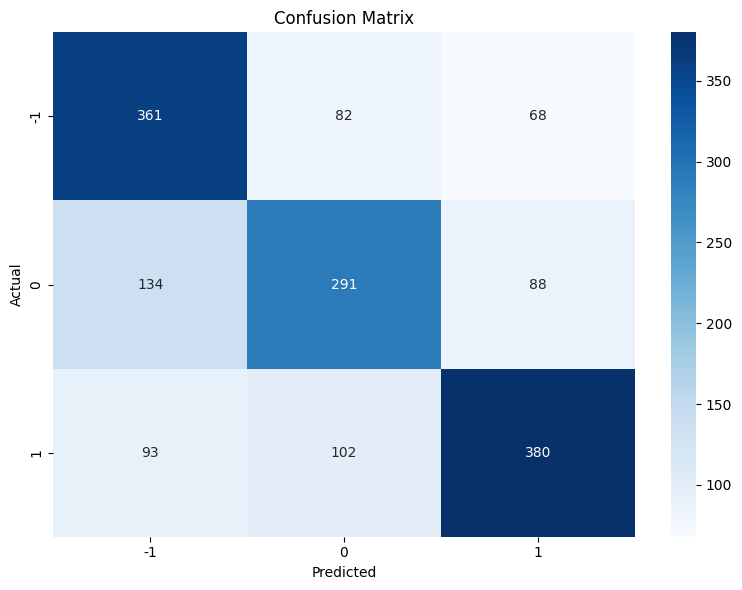

In [17]:
# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix_gridsearch.png")
plt.show()

In [ ]:
# 11. Save model dan vectorizer
joblib.dump(best_model, "naive_bayes_best_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

In [ ]:
# 12. Save cleaned dataset
df.to_csv("cleaned_dataset_final.csv", index=False)
